In [22]:
import pandas as pd, numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt, seaborn as sns
from os import listdir

metadata = pd.read_excel(
    "./metadata.xlsx",
    sheet_name=1,
    header=10
)

file_names = listdir("./census_data")
file_names = sorted([file_name for file_name in file_names if ".csv" in file_name])

for i, file_name in enumerate(file_names):
    
    key = file_name.split("_")[1]
    
    file_data = pd.read_csv(
        f"./census_data/{file_name}",
        index_col="SAL_CODE_2021"
    )
    
    file_data.columns = [
        metadata[
            (metadata.DataPackfile == key) &
            (metadata.Short == string)
        ].iat[0, 2].lower() for string in file_data.columns
    ]
            
    if i == 0:
        suburb_data = file_data
    
    else:        
        suburb_data = suburb_data.join(
            file_data,
            lsuffix=f"_v{i}"
        )

suburb_data.to_csv("./raw_suburb_data.csv")

act_suburbs = pd.read_csv(
    "./act_suburbs.csv"
)
act_suburbs.code = "SAL" + act_suburbs.code.astype("str")

PermissionError: [Errno 13] Permission denied: './raw_suburb_data.csv'

In [55]:
data = pd.DataFrame(
    index=act_suburbs.code,
    data={
        "name": act_suburbs.name.to_list(),
        "belco":  act_suburbs.belco.to_list()
    }
)

data["population"] = suburb_data.total_persons_persons
data = data[data.population >= 30]
suburb_data = suburb_data.loc[data.index]

data["masculinity"] = suburb_data.total_persons_males / data.population
data["age_under_5"] = suburb_data.age_groups_0_4_years_persons / data.population
data["age_under_15"] = suburb_data.age_groups_5_14_years_persons / data.population + data.age_under_5
data["age_under_20"] = suburb_data.age_groups_15_19_years_persons / data.population + data.age_under_15
data["age_under_25"] = suburb_data.age_groups_20_24_years_persons / data.population + data.age_under_20
data["age_under_35"] = suburb_data.age_groups_25_34_years_persons / data.population + data.age_under_25
data["age_under_45"] = suburb_data.age_groups_35_44_years_persons / data.population + data.age_under_35
data["age_under_55"] = suburb_data.age_groups_45_54_years_persons / data.population + data.age_under_45
data["age_under_65"] = suburb_data.age_groups_55_64_years_persons / data.population + data.age_under_55
data["age_under_75"] = suburb_data.age_groups_65_74_years_persons / data.population + data.age_under_65
data["age_under_85"] = suburb_data.age_groups_75_84_years_persons / data.population + data.age_under_75
data["indigenous"] = suburb_data.aboriginal_and_or_torres_strait_islander_persons_total_persons / data.population
data["born_overseas"] = suburb_data.birthplace_elsewhere_persons / data.population
data["other_language"] = suburb_data.language_used_at_home_other_language_persons / data.population
data["citizens"] = suburb_data.australian_citizen_persons / data.population

data

,name,belco,population,masculinity,age_under_5,age_under_15,age_under_20,age_under_25,age_under_35,age_under_45,age_under_55,age_under_65,age_under_75,age_under_85,indigenous,born_overseas,other_language,citizens
code,,,,,,,,,,,,,,,,,,
SAL80017,Acton,0,2848.0,0.448385,0.001756,0.001756,0.510885,0.883076,0.976826,0.994733,0.997191,0.997191,0.997191,0.997191,0.007725,0.261938,0.200843,0.687851
SAL80018,Ainslie,0,5376.0,0.471726,0.048549,0.166481,0.221726,0.294457,0.406622,0.535714,0.672619,0.800967,0.896763,0.954613,0.018415,0.219866,0.126488,0.915551
SAL80019,Amaroo,0,6129.0,0.495676,0.060858,0.226138,0.305760,0.370370,0.498287,0.654430,0.827704,0.919400,0.970958,0.993637,0.018274,0.257138,0.238049,0.895252
SAL80020,Aranda,1,2605.0,0.487524,0.054511,0.196929,0.251440,0.314395,0.418042,0.550480,0.680998,0.811132,0.903647,0.979271,0.010365,0.256814,0.152399,0.888292
SAL80021,Banks,0,5100.0,0.499020,0.062549,0.212353,0.280588,0.349412,0.497255,0.648627,0.800196,0.916078,0.969216,0.994314,0.028235,0.181765,0.149216,0.934118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAL80131,Watson,0,6727.0,0.484466,0.065408,0.199792,0.246767,0.313215,0.502453,0.687379,0.814925,0.905456,0.959566,0.990783,0.018433,0.261930,0.196670,0.861008
SAL80132,Weetangera,1,2795.0,0.499106,0.046512,0.184258,0.260107,0.318068,0.419678,0.547406,0.691950,0.796064,0.894812,0.973166,0.006440,0.237567,0.177460,0.901968
SAL80133,Weston,0,4000.0,0.483250,0.057000,0.189500,0.241500,0.288500,0.393500,0.535500,0.672250,0.765250,0.865750,0.957500,0.009000,0.252750,0.188500,0.885000


<AxesSubplot:xlabel='citizens', ylabel='Count'>

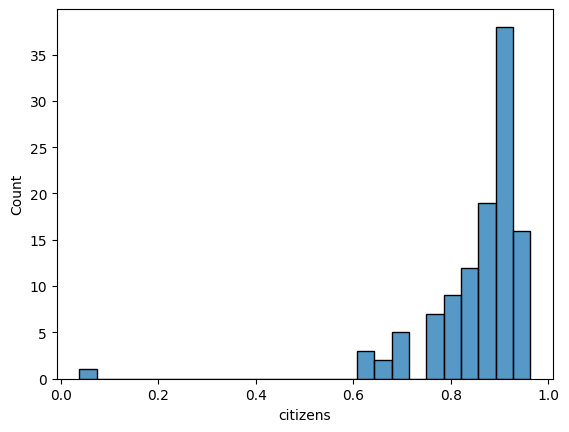

In [57]:
sns.histplot(
    data=data.citizens    
)

In [58]:
data.sort_values("born_overseas")

,name,belco,population,masculinity,age_under_5,age_under_15,age_under_20,age_under_25,age_under_35,age_under_45,age_under_55,age_under_65,age_under_75,age_under_85,indigenous,born_overseas,other_language,citizens
code,,,,,,,,,,,,,,,,,,
SAL80128,Uriarra Village,0,309.0,0.517799,0.064725,0.268608,0.330097,0.372168,0.495146,0.708738,0.854369,0.948220,0.967638,0.977346,0.012945,0.080906,0.000000,0.954693
SAL80123,Tharwa,0,82.0,0.500000,0.085366,0.207317,0.268293,0.268293,0.487805,0.560976,0.670732,0.841463,0.939024,0.939024,0.036585,0.097561,0.048780,0.963415
SAL80077,Hume,0,395.0,0.926582,0.000000,0.007595,0.035443,0.129114,0.518987,0.779747,0.921519,0.962025,0.977215,1.002532,0.253165,0.126582,0.000000,0.037975
SAL80070,Hall,0,298.0,0.503356,0.020134,0.187919,0.291946,0.325503,0.379195,0.473154,0.657718,0.795302,0.953020,1.040268,0.030201,0.134228,0.053691,0.956376
SAL80111,Pialligo,0,138.0,0.500000,0.079710,0.166667,0.202899,0.304348,0.326087,0.413043,0.608696,0.768116,0.847826,0.884058,0.065217,0.159420,0.028986,0.862319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAL80058,Franklin,0,7484.0,0.506146,0.071619,0.201363,0.249065,0.332175,0.591128,0.789417,0.904864,0.959514,0.989177,0.996927,0.014564,0.494923,0.530331,0.712320
SAL80085,Lawson,0,2739.0,0.514421,0.057685,0.129974,0.162468,0.339540,0.717780,0.877693,0.941950,0.975173,0.994158,0.998540,0.011683,0.496897,0.504929,0.654984
SAL80125,Throsby,0,2405.0,0.513514,0.110187,0.296881,0.335135,0.378378,0.592100,0.834096,0.932225,0.970062,0.990852,0.998753,0.009979,0.499792,0.593763,0.806237
